In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")

## **ARIMA Model for Forecasting**

A popular and widely used statistical method for time series forecasting is the ARIMA model. ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a class of model that captures a suite of different standard temporal structures in time series data.

**Autoregressive Integrated Moving Average Model**

An ARIMA model is a class of statistical models for analyzing and forecasting time series data. It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts. This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:
- **AR:** *Autoregression.* A model that uses the dependent relationship between an observation and some number of lagged observations.
- **I:** *Integrated.* The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- **MA:** *Moving Average*. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used. 
The parameters of the ARIMA model are defined as follows:

- **p:** The number of lag observations included in the model, also called the lag order.
- **d:** The number of times that the raw observations are differenced, also called the degree of differencing.
- **q:** The size of the moving average window, also called the order of moving average.

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model. A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

Adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. This may seem obvious, but helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model.

In [2]:
# Load dataset
def parser(x):
    return pd.datetime.strptime("190"+x, "%Y-%m")

series = pd.read_csv('monthly-shampoo-sales.csv', header=0, index_col=0,parse_dates=True,
                    date_parser=parser,squeeze=True)

# Summarize first few rows
series.head()

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64

Text(0.5, 1.0, 'Line plot of the Shampoo Sales dataset.')

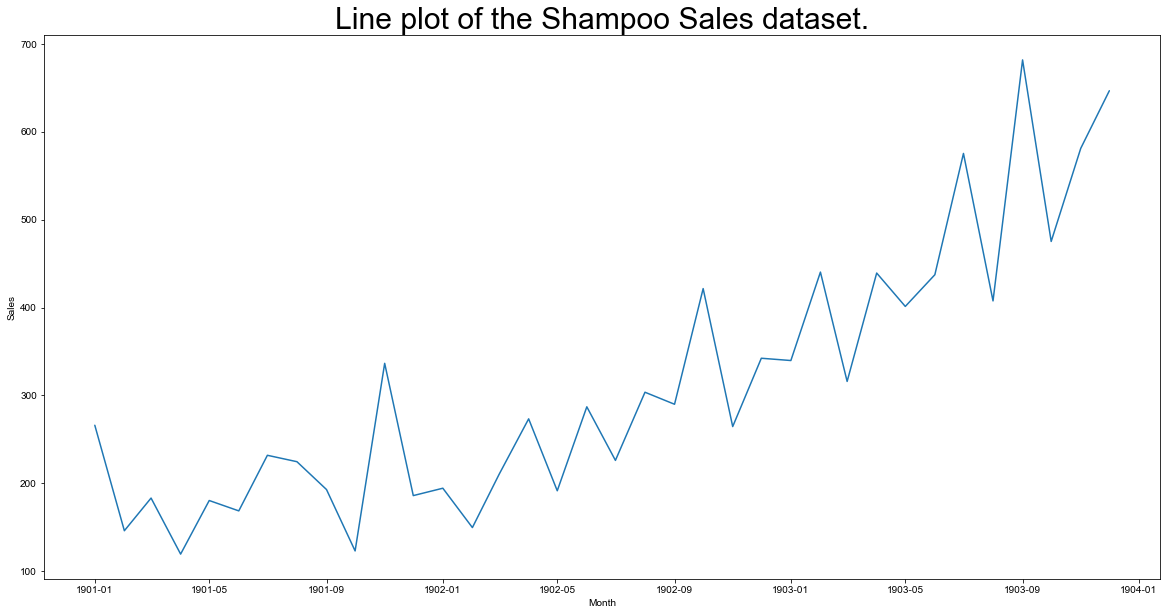

In [3]:
fig,ax = plt.subplots(figsize=(20,10))
sns.set_theme(style="whitegrid")
sns.lineplot(data=series)
ax.set_title("Line plot of the Shampoo Sales dataset.",fontdict={"fontsize":30})

We can see that the Shampoo Sales dataset has a clear trend. This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1. Let's also take a quick look at an autocorrelation plot of the time series.

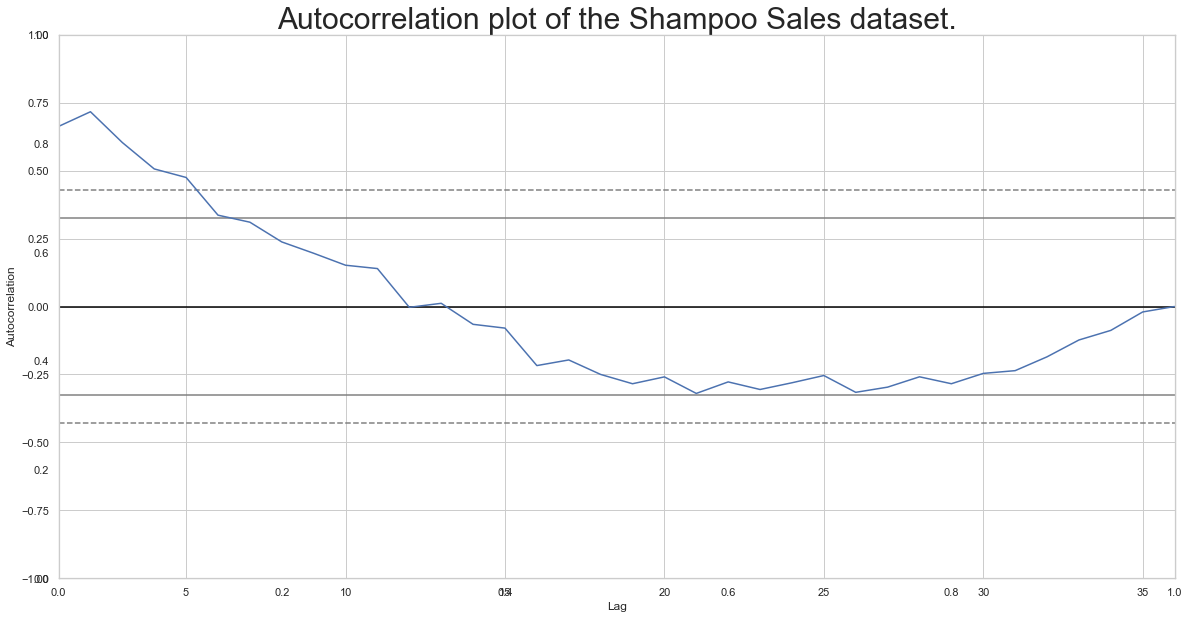

In [4]:
fig,ax = plt.subplots(figsize=(20,10))
pd.plotting.autocorrelation_plot(series)
ax.set_title("Autocorrelation plot of the Shampoo Sales dataset.",fontdict={"fontsize":30})
plt.grid()

Running the example, we can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags. A good starting point for the AR parameter of the model may be 5.

**ARIMA with Python**

The Statsmodels library provides the capability to fit an ARIMA model. An ARIMA model can be created using the Statsmodels library as follows:
1. Define the model by calling ARIMA() and passing in the p, d, and q parameters.
2. The model is prepared on the training data by calling the fit() function.
3. Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.

Let's start off with something simple. We will fit an ARIMA model to the entire Shampoo Sales dataset and review the residual errors. First, we fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0. When fitting the model, a lot of debug information is provided about the fit of the linear regression model. We can turn this off by setting the disp argument to 0.

In [81]:
# Load dataset
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
def parser(x):
    return pd.datetime.strptime("190"+x, "%Y-%m")

series = pd.read_csv('monthly-shampoo-sales.csv', header=0, index_col=0,parse_dates=True,
                    date_parser=parser,squeeze=True)

# Needs to resampled in from years-months-days to years-months                    
series.index = series.index.to_period('M')

In [82]:
series.head()

Month
1901-01    266.0
1901-02    145.9
1901-03    183.1
1901-04    119.3
1901-05    180.3
Freq: M, Name: Sales, dtype: float64

In [83]:
# from statsmodels.tsa.arima_model import ARIMA -> this has deprecated
from statsmodels.tsa.arima.model import ARIMA

# Fit model
model = ARIMA(series,order=(5,1,0))
# model_fit = model.fit(disp=0) # using this will generate an error 
# due to the argument "disp" being passed in
model_fit = model.fit()

# Summary of fit model
print(f"Summary of fit model\n{model_fit.summary()}")

# Line plot of residuals 
residuals = pd.DataFrame(model_fit.resid)


Summary of fit model
                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -198.485
Date:                Thu, 28 Apr 2022   AIC                            408.969
Time:                        12:13:27   BIC                            418.301
Sample:                    01-31-1901   HQIC                           412.191
                         - 12-31-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9014      0.247     -3.647      0.000      -1.386      -0.417
ar.L2         -0.2284      0.268     -0.851      0.395      -0.754       0.298
ar.L3          0.0747      0.29

In [84]:
# Flattening the Multiindex dataframe
residuals_flat = residuals.reset_index()
# Renaming the columns
cols = {"Month":"month"}
residuals_flat.rename(columns=cols,inplace=True)
residuals_flat.columns
# adding a column
residuals_flat['residual_values'] = residuals_flat[0]
# Dropping a column
residuals_flat.drop(columns=[0],inplace=True)
residuals_flat.columns

Index(['month', 'residual_values'], dtype='object')

Summary stats of residuals
       residual_values
count        36.000000
mean         21.936144
std          80.774430
min        -122.292030
25%         -35.040859
50%          13.147219
75%          68.848286
max         266.000000


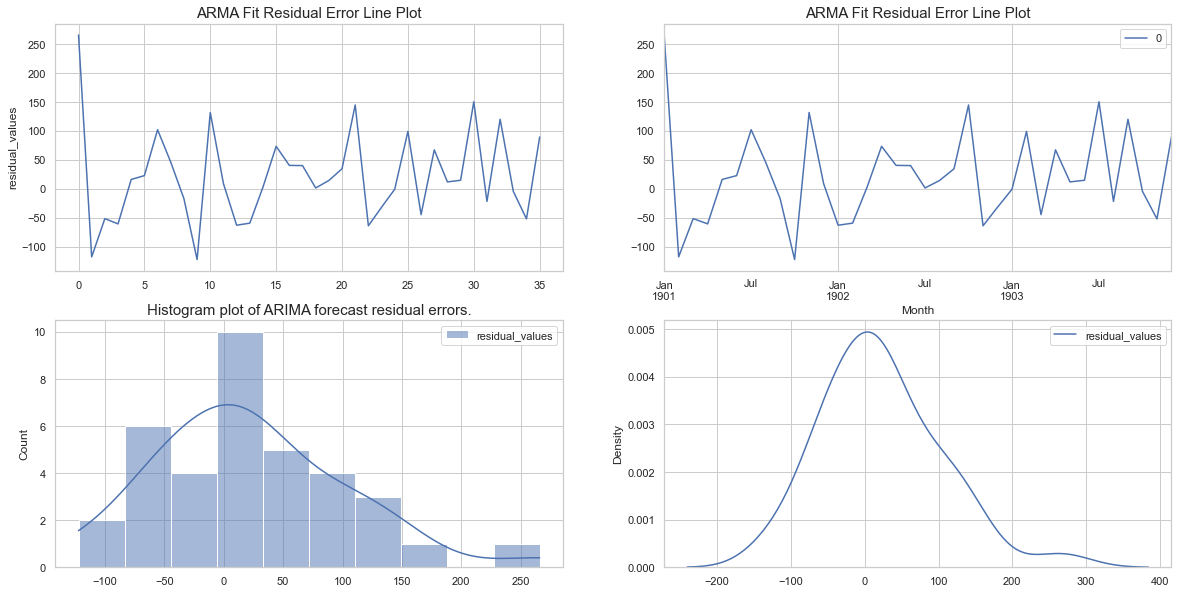

In [95]:
fig, ax = plt.subplots(2,2,figsize=(20,10))
sns.set_theme(style='whitegrid')

sns.lineplot(data=residuals_flat,x=residuals_flat.index,y="residual_values",ax=ax[0,0])
ax[0,0].set_title("ARMA Fit Residual Error Line Plot", fontdict={'fontsize':15})
# plt.grid()

residuals.plot(ax=ax[0,1])
ax[0,1].set_title("ARMA Fit Residual Error Line Plot", fontdict={'fontsize':15})

# Histogram density plot
sns.histplot(data=residuals_flat,bins=10,kde=True, ax=ax[1,0])
ax[1,0].set_title("Histogram plot of ARIMA forecast residual errors.", fontdict={'fontsize':15})
# plt.grid()

# kde density plot
sns.kdeplot(data=residuals_flat,ax=ax[1,1])
# ax[1,1].set_title("Density plot of ARIMA forecast residual errors.", fontdict={'fontsize':15})
# plt.grid()
# plt.subplots_adjust(wspace=0.2, hspace=0.2)
# Summary stats of residuals
print(f"Summary stats of residuals\n{residuals_flat.describe()}")

The distribution of the residual errors is displayed. **The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).**

*Note, that although above we used the entire dataset for time series analysis, ideally we would perform this analysis on just the training dataset when developing a predictive model. Next, let's look at how we can use the ARIMA model to make forecasts.*

**Rolling Forecast ARIMA Model**

The ARIMA model can be used to forecast future time steps. We can use the predict() function on the ARIMAResults object to make predictions. It accepts the index of the time steps to make predictions as arguments. These indexes are relative to the start of the training dataset used to make predictions. 

If we used 100 observations in the training dataset to fit the model, then the index of the next time step for making a prediction would be specified to the prediction function as start=101, end=101. This would return an array with one element containing the prediction. We also would prefer the forecasted values to be in the original scale, in case we performed any differencing (d > 0 when configuring the model). This can be specified by setting the typ argument to the value 'levels': typ='levels'. 

Alternately, we can avoid all of these specifications by using the forecast() function which performs a one-step forecast using the model. We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received. We manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended each iteration.

In [98]:
# evaluate an ARIMA model using a walk-forward validation
from sklearn.metrics import mean_squared_error

# Split into train and test sets
X = series.values
size = int(len(X)* 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

# Walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f"Predicted: {yhat}, Expected: {obs}")

# Evaluate Forecasts
rmse = mean_squared_error(test,predictions,squared=False)
print(f"RMSE: {rmse}")

Predicted: 343.2721804142173, Expected: 342.3
Predicted: 293.32967411680767, Expected: 339.7
Predicted: 368.6689556923214, Expected: 440.4
Predicted: 335.044740638034, Expected: 315.9
Predicted: 363.2202215171502, Expected: 439.3
Predicted: 357.64532347323683, Expected: 401.3
Predicted: 443.04783536696334, Expected: 437.4
Predicted: 378.3656734866571, Expected: 575.5
Predicted: 459.41502048414446, Expected: 407.6
Predicted: 526.8908755663845, Expected: 682.0
Predicted: 457.23127476167883, Expected: 475.3
Predicted: 672.9149433869607, Expected: 581.3
Predicted: 531.5414492158278, Expected: 646.9
RMSE: 89.0210558638927


Text(0.5, 1.0, 'Line plot of expected values (blue) and rolling forecast (red) with an ARIMA model')

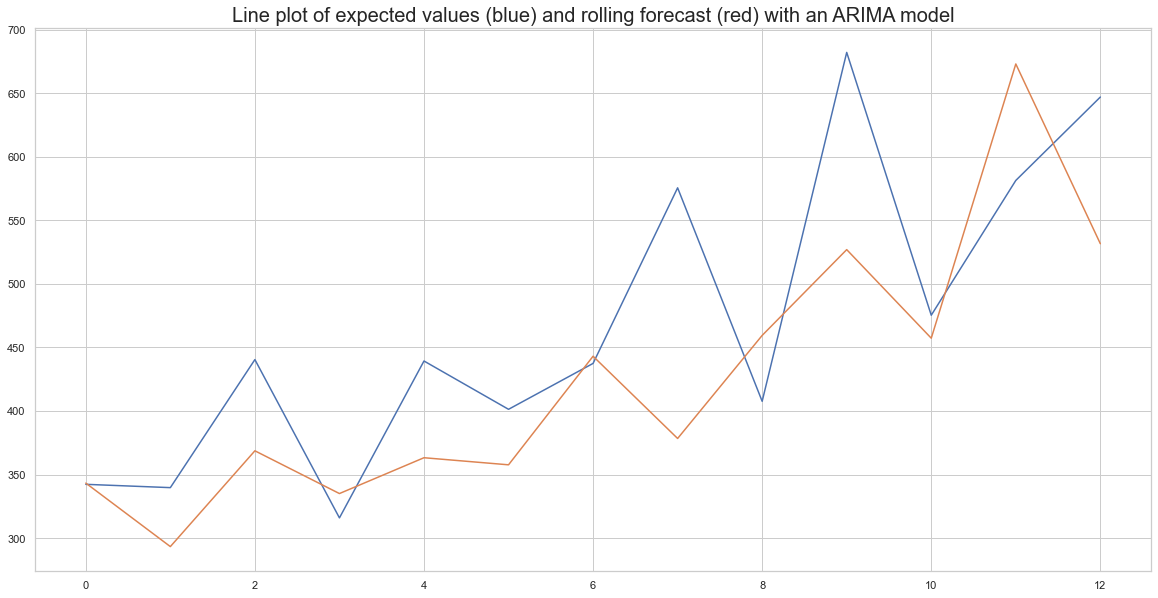

In [100]:
# Forecast vs Actual outcomes plots
fig, ax = plt.subplots(figsize=(20,10))
sns.set_theme(style='whitegrid')

sns.lineplot(data=test)
sns.lineplot(data=predictions)
ax.set_title("Line plot of expected values (blue) and rolling forecast (red) with an ARIMA model", fontdict={'fontsize':20})

The model could use further tuning of the p, d, and maybe even the q parameters.